# Ensemble Learning Project - Exoplanet Detection

Supervised by : Myriam TAMI

From : Thomas GEORGES & Manon LAGARDE

## 1. Read the Data : 

First, we load the dataset from the `cumulative.csv` file, which contains exoplanet candidate data.

In [534]:
# IMPORT STATEMENTS : 
######################################################################################
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline

In [535]:
# READ DATA FROM GOOGLE DRIVE / FOLDER : 
######################################################################################
# GOOGLE COLAB :
#from google.colab import drive
#drive.mount('/content/drive')
#folder_path = '/content/drive/MyDrive/Ensemble Learning/cumulative.csv'

# VSC :
folder_path = '/Users/CentraleSupelec/Documents/CentraleSupelec/Ensemble Learning/Project/cumulative.csv'

# DATASET :
######################################################################################
data_train = pd.read_csv(folder_path)
N, D = data_train.shape
print(f"There are {N} rows (exoplanet candidates) and {D} columns (features) in this csv.")
data_train.head()

There are 9564 rows (exoplanet candidates) and 50 columns (features) in this csv.


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## 2. Data Preparation :

### 2.1. Data Information & Cleanup :

Important Information about the Kepler Dataset, more specifically the definition of each columns, can be found here : https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [536]:
# PRELIMINARY INFORMATION ABOUT THE DATASET :
######################################################################################
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

We can start by removing irrelevant features from the dataset for the following reasons : 

[1] Identification Features :

- `rowid` : Index
- `kepid` : Kepler ID, unique identifier with no predictive value.
- `kepoi_name` : Kepler Object of Interest name.
- `kepler_name` : Name assigned to confirmed planets.

[2] Label-Related Features : 

- `koi_disposition` : Final classification 
- `koi_pdisposition` : Processed classification
- `koi_score` : Probability score assigned to candidates

[3] Administrative / Metadata Features : 

- `koi_tce_plnt_num` : TCE number, non-predictive.
- `koi_tce_delivname` : TCE delivery identifier, administrative only.

In [537]:
# DATA CLEANUP : 
######################################################################################
features_to_drop = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_tce_plnt_num', 'koi_tce_delivname']
#print("\nDropped Features:", features_to_drop)

data_train_features = data_train.drop(columns=features_to_drop)
print("Number of Features left :", data_train_features.shape[1])

Number of Features left : 41


In [538]:
# SEPARATING CATEGORICAL & NUMERICAL FEATURES :
######################################################################################
categorical = data_train_features.select_dtypes(include =['object'])
print("Categorical Features in DataSet :", categorical.shape[1])
#print(categorical.columns)

numerical = data_train_features.select_dtypes(include =['number'])
print("Numerical Features in DataSet :", numerical.shape[1])
#print(numerical.columns)

Categorical Features in DataSet : 0
Numerical Features in DataSet : 41


We can note that we only have numerical variables left after the data cleanup.

### 2.2. Handling Missing Values : 

In order to ensure a complete dataset, we then handle missing values in the data.

In [539]:
# HANDLING MISSING VALUES : 
######################################################################################
def missing_values(dataset) : 
    null_counts = dataset.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    print(null_counts)

missing_values(data_train_features)

koi_period_err1       454
koi_period_err2       454
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad              363
koi_srad_err1         468
koi_srad_err2         468
koi_kepmag              1
dtype: int64


The following columns have a high majority of null values and can be discarded : 
- `koi_teq_err1`
- `koi_teq_err2`

The rest of the numerical columns can be handled using the mean for the missing values.

In [540]:
# Discard Features with majority of null values in the Dataset : 
data_train_features = data_train_features.drop(columns=['koi_teq_err1', 'koi_teq_err2'])

In [541]:
# MISSING NUMERICAL FEATURES HANDLING : 
######################################################################################
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(data_train_features)
df = pd.DataFrame(df_imputed, columns=data_train_features.columns)

missing_values(df)

Series([], dtype: int64)


### 2.3. Correlation Matrix :

In [542]:
# CREATING BINARY TARGET VARIABLE FOR EXOPLANET CANDIDATE CLASSIFICATION :
######################################################################################
df['is_candidate'] = (data_train['koi_pdisposition'] == 'CANDIDATE').astype(int)
print(df['is_candidate'].value_counts())

is_candidate
0    5068
1    4496
Name: count, dtype: int64


To identify the features most correlated with exoplanet candidacy, we will analyze the top numerical features and their relationship with the target variable.

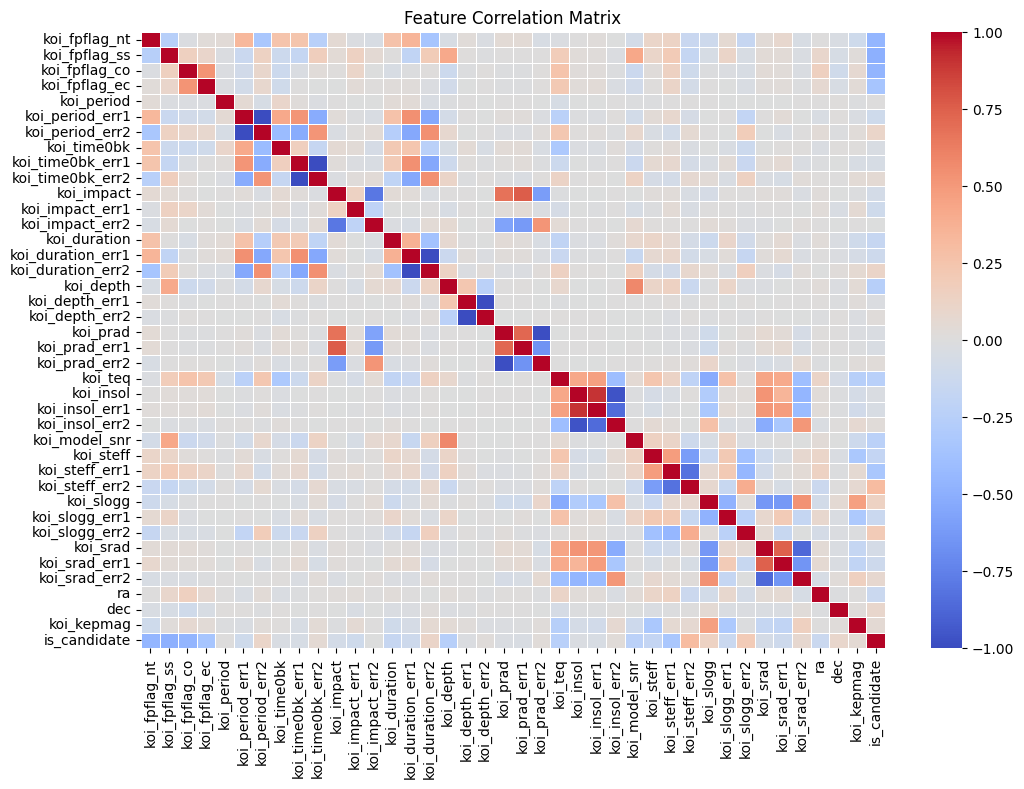

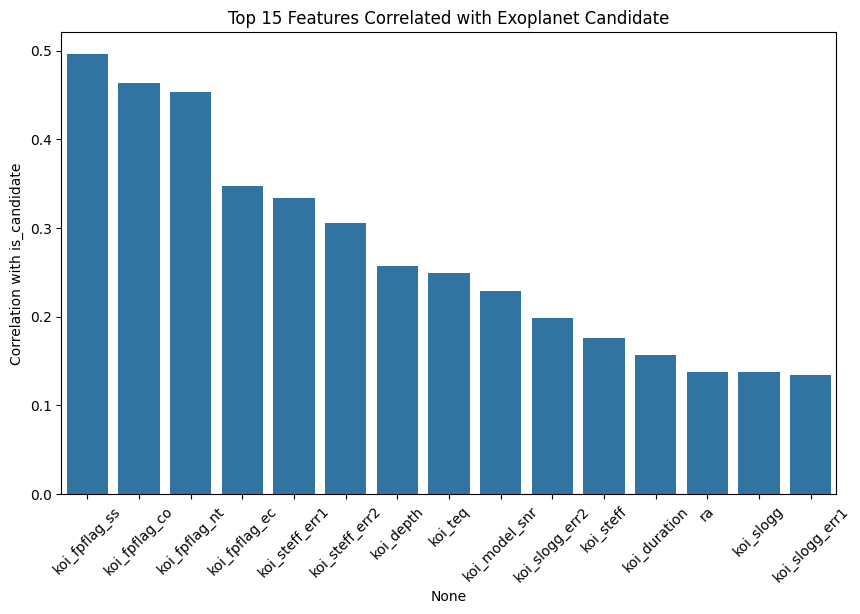

In [543]:
# COMPUTE CORRELATION MATRIX :
######################################################################################
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['is_candidate'].drop('is_candidate')
correlation_sorted = correlation_with_target.abs().sort_values(ascending=False) # most important features first

# CORRELATION HEATMAP : 
######################################################################################
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Display Top 10 Features as a List : 
top_10_features = correlation_sorted.head(10).index.tolist()
#print("Top 10 Features :", top_10_features)

# Display correlations
#print("\nTop 15 Features Most Correlated with 'is_candidate':")
#print(correlation_sorted.head(15))

# Plot top 15 Features Most Correlated with 'is_candidate':
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_sorted.head(15).index, y=correlation_sorted.head(15).values)
plt.xticks(rotation=45)
plt.title('Top 15 Features Correlated with Exoplanet Candidate')
plt.ylabel('Correlation with is_candidate')
plt.show()

**Feature Correlation Analysis :**  

The Feature Correlation Matrix provides insights into relationships between different variables in the dataset.  

1. **Strongly Positively Correlated Features (Red Squares):** Features with a correlation close to 1 vary together, indicating a possible dependency or/and redundancy. For example, `koi_srad_err1` (uncertainty in stellar radius) is highly correlated with `koi_srad` (stellar radius), which makes sense since they are related.

2. **Strongly Negatively Correlated Features (Blue Squares) :** Features with a correlation close to -1 move in opposite directions, indicating a possible dependency. For examples, `koi_srad_err2` (lower uncertainty in stellar radius) is negatively correlated with `koi_srad`, meaning that as one increases, the other decreases.  

3. **Features Correlated with `is_candidate` :** The last row of the correlation matrix highlights features that have a strong relationship with the target variable (`is_candidate`). These features are critical for classification.  

To further refine feature selection, we also added the top 15 most important features correlated to Exoplanet Candidacy.  

**Actions to take for Feature Selection Based on Correlation Analysis :**  

1. To improve model performance, we will first remove features with **very low correlation** (below **0.05**), as they likely contribute little useful information and may introduce unnecessary noise.  

2. Since **highly correlated features** may provide redundant information, a deeper analysis is needed to determine which ones can be removed. We will compute **pairwise correlations** and eliminate the **least informative feature** from each highly correlated pair to optimize the dataset.

In [544]:
# DROP LOW CORRELATION FEATURES (<0.05) : 
######################################################################################
low_correlation_features = correlation_with_target[correlation_with_target.abs() < 0.05].index.tolist()
df = df.drop(columns = low_correlation_features)

# Print removed features :
print("\nRemoved Features (Low Correlation < 0.05):", low_correlation_features)

# Print remaining features :
print("\nRemaining Features After Removal:", df.columns.tolist())
print("Number of Features left :", df.shape[1])


Removed Features (Low Correlation < 0.05): ['koi_period', 'koi_time0bk', 'koi_impact_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2']

Remaining Features After Removal: ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_teq', 'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', 'is_candidate']
Number of Features left : 29


In [545]:
# Identify highly correlated features (> 0.75)
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                   if col1 != col2 and correlation_matrix.loc[col1, col2] > 0.75]

print("Highly Correlated Feature Pairs:")
for pair in high_corr_pairs:
    print(pair)
    
# Filter out pairs where one element was removed due to low correlation
filtered_high_corr_pairs = [(col1, col2) for col1, col2 in high_corr_pairs
                            if col1 in df.columns and col2 in df.columns]

# Print the filtered highly correlated feature pairs
print("\nHighly Correlated Feature Pairs (After Removing Low Correlation Features):")
for pair in filtered_high_corr_pairs:
    print(pair)


Highly Correlated Feature Pairs:
('koi_impact', 'koi_prad_err1')
('koi_prad_err1', 'koi_impact')
('koi_insol', 'koi_insol_err1')
('koi_insol_err1', 'koi_insol')

Highly Correlated Feature Pairs (After Removing Low Correlation Features):


This correlation analysis helped us optimize the dataset by removing redundant and low correlated features while preserving the most informative variables for accurate exoplanet prediction.

### 2.4. Data Visualization : 

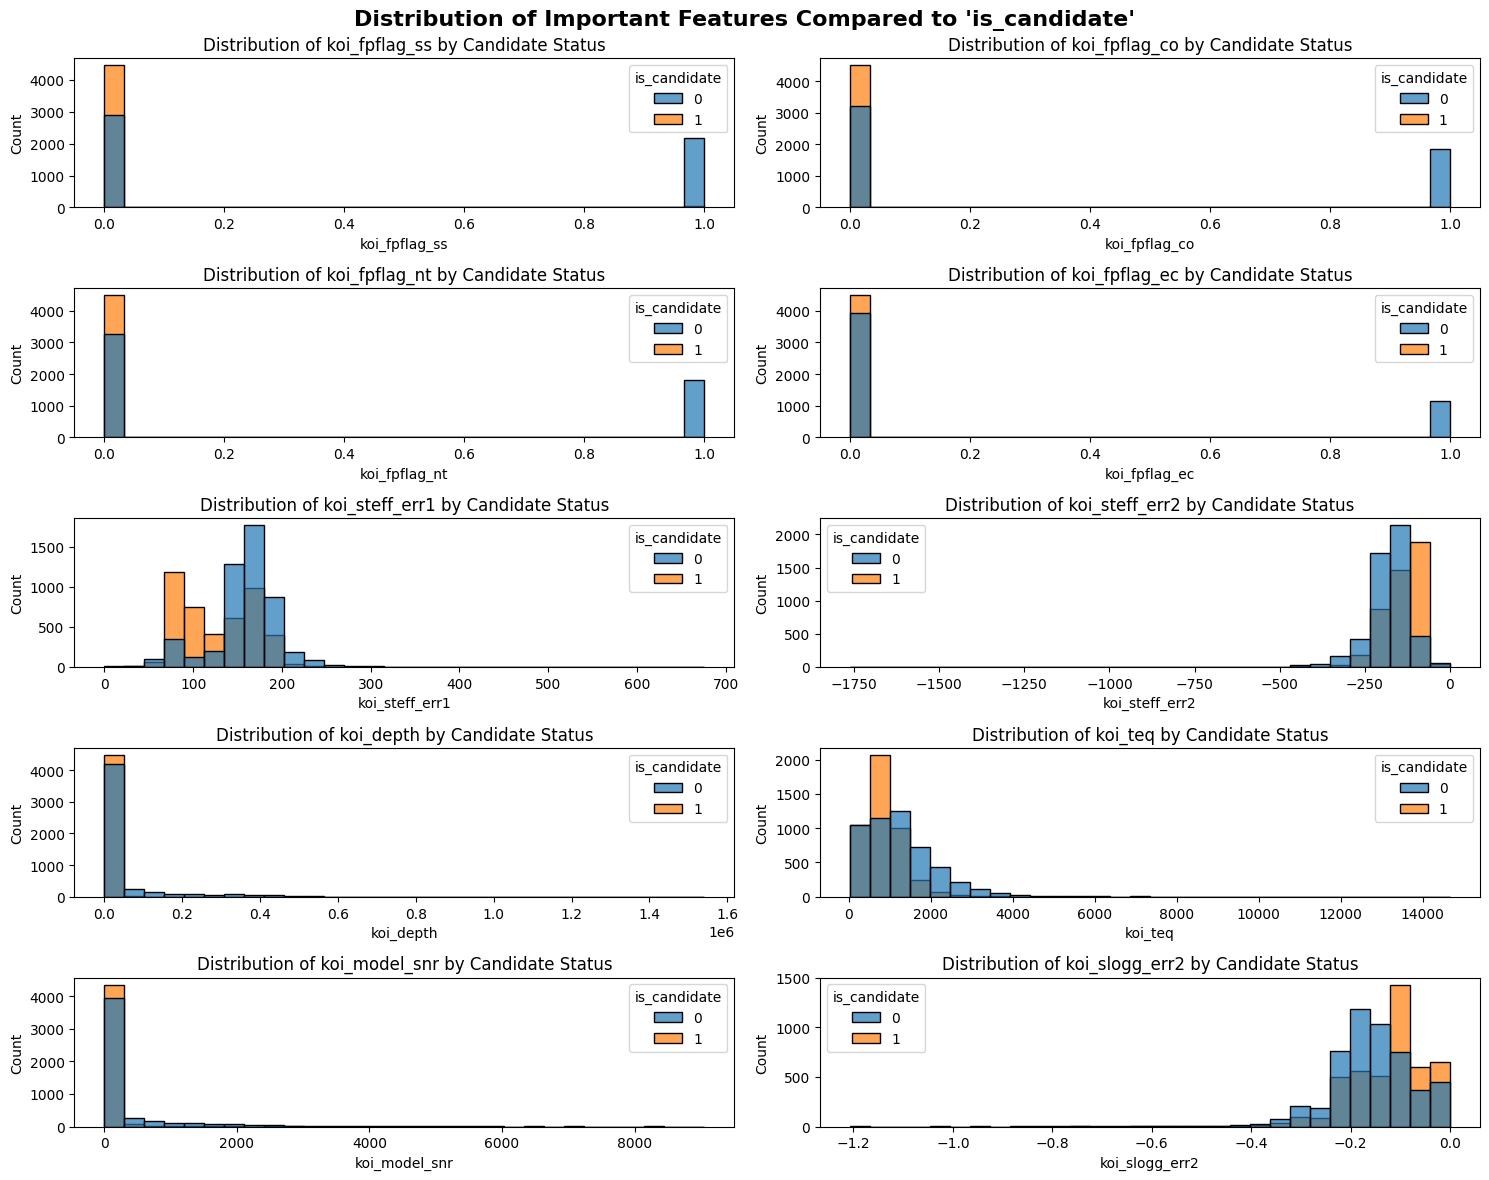

In [546]:
# Plot distribution of each top 10 feature compared to 'is_candidate' :
######################################################################################
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of Important Features Compared to 'is_candidate'", fontsize=16, fontweight="bold")

for i, feature in enumerate(top_10_features, 1):
    plt.subplot(5, 2, i)
    sns.histplot(data=df, x=feature, hue="is_candidate", bins=30, alpha=0.7)
    plt.title(f"Distribution of {feature} by Candidate Status")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Analysis of Feature Distributions by Candidate Status :**

The histograms compare the distributions of top 10 important features between **exoplanet candidates (`is_candidate=1`) and non-candidates (`is_candidate=0`)**.  

- We have 4 Binary Features (`koi_fpflag_ss`, `koi_fpflag_co`, `koi_fpflag_nt`, `koi_fpflag_ec`) that show clear separations, indicating strong predictive power for candidate classification.  
- For Stellar Temperature Errors (`koi_steff_err1`, `koi_steff_err2`) show some slight different distributions. While for Equilibrium Temperature (`koi_teq`) and Stellar Surface Gravity `koi_slogg_err2` we see some more significant difference in the distribution.
- For Transit Depth (`koi_depth`) & Model Signal-to-Noise Ratio (`koi_model_snr`), we don't notice a big difference between the two groups.

## 3. Building Models :

We will be using the 'koi_pdisposition' as the target variable, which has two classes : 

[1] <span style="color:green">'CANDIDATE'</span> -> Possible Exoplanet

[2] <span style="color:red">'FALSE POSITIVE'</span> -> Not an Exoplanet

Since it is a categorical variable, we will convertt it into a binary variable ( '1' -> 'CANDIDATE' and '0' -> 'FALSE POSITIVE' )

Our objective will be to create a model to predict the likelihood of a KOI to be a Candidate exoplanet.

In [547]:
# IMPORT STATEMENT : 
######################################################################################
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc


In [548]:
# DEFINE DATA AND TARGET VARIABLE :
######################################################################################
y = df['is_candidate'] 
X = df.drop(columns=['is_candidate'])

# STANDARDIZATION : 
######################################################################################
original_feature_names = X.columns 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# SPLIT DATASET INTO TRAINING AND TESTING (80% Training and 20% Testing) : 
######################################################################################
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")

X_train = pd.DataFrame(X_train, columns=original_feature_names)
X_test = pd.DataFrame(X_test, columns=original_feature_names)

Training Samples: (7651, 28), Test Samples: (1913, 28)


In [549]:
# ALTERNATIVE TRAIN-TEST SPLIT DATASET (70% Training and 30% Testing) : 
######################################################################################
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training Samples: {X_train1.shape}, Test Samples: {X_test1.shape}")

X_train1 = pd.DataFrame(X_train1, columns=original_feature_names)
X_test1 = pd.DataFrame(X_test1, columns=original_feature_names)

Training Samples: (6694, 28), Test Samples: (2870, 28)


### 3.1 Random Forest Classifier :

In [550]:
# RANDOM FOREST - TEST 1 : 
######################################################################################
rf1 = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    random_state=42
)

rf1.fit(X_train, y_train)

train_accuracy_rf1 = accuracy_score(y_train, rf1.predict(X_train))
test_accuracy_rf1 = accuracy_score(y_test, rf1.predict(X_test))

print("Random Forest Classifier - Model 1 (Baseline): ")
print("\nTraining Accuracy:", train_accuracy_rf1)
print("Testing Accuracy:", test_accuracy_rf1)

# CROSS-VALIDATION ACCURACY : 
######################################################################################
cv_scores_rf1 = cross_val_score(rf1, X, y, cv=5, scoring='accuracy')
mean_cv_scores_rf1 = np.mean(cv_scores_rf1)

print("\nCross-Validation Accuracy Scores:", cv_scores_rf1)
print("Mean Accuracy:", mean_cv_scores_rf1)

# CLASSIFIFCATION REPORT :
######################################################################################
print("\nClassification Report:")
print(classification_report(y_test, rf1.predict(X_test)))

Random Forest Classifier - Model 1 (Baseline): 

Training Accuracy: 1.0
Testing Accuracy: 0.9874542603240982

Cross-Validation Accuracy Scores: [0.97543126 0.99424987 0.96497648 0.99477261 0.94142259]
Mean Accuracy: 0.9741705616930624

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1014
           1       0.99      0.98      0.99       899

    accuracy                           0.99      1913
   macro avg       0.99      0.99      0.99      1913
weighted avg       0.99      0.99      0.99      1913



**Analysis of Random Forest Model Performance :**  

- The **training accuracy** of 1.0 shows that the model perfectly classifies the training data. This could indicate potential overfitting.
- The **testing accuracy** of 0.9874 and mean cross-validation accuracy of 0.9741 shows strong generalization.  
- The slight difference in cross-validation scores (range: 94.1% - 99.4%) suggests some variability across folds. 
- The **classification report** highlights high precision, recall, and F1-scores (~0.99) for both classes, meaning the model effectively classifies exoplanet candidates and non-candidates.  

**Next Steps:** We will focus on reducing overfitting by tuning `max_depth` and increasing `min_samples_leaf` in our upcoming model.

Before proceeding, we will test a different train-test split (70% training, 30% testing) to check if our model's performance depends on the current 80%-20% split :

In [551]:
# RANDOM FOREST - TEST 2 (on Alternative Train-Test Split, i.e. 70% Training and 30% Testing) : 
######################################################################################
rf1.fit(X_train1, y_train1)

train_accuracy_rf1 = accuracy_score(y_train, rf1.predict(X_train))
test_accuracy_rf1 = accuracy_score(y_test, rf1.predict(X_test))

print("Random Forest Classifier - Model 1 (Different train-test split): ")
print("\nTraining Accuracy:", train_accuracy_rf1)
print("Testing Accuracy:", test_accuracy_rf1)

# CROSS-VALIDATION ACCURACY : 
######################################################################################
cv_scores_rf1 = cross_val_score(rf1, X, y, cv=5, scoring='accuracy')
mean_cv_scores_rf1 = np.mean(cv_scores_rf1)

print("\nCross-Validation Accuracy Scores:", cv_scores_rf1)
print("Mean Accuracy:", mean_cv_scores_rf1)

Random Forest Classifier - Model 1 (Different train-test split): 

Training Accuracy: 0.9984315775715593
Testing Accuracy: 0.9879769994772608

Cross-Validation Accuracy Scores: [0.97543126 0.99424987 0.96497648 0.99477261 0.94142259]
Mean Accuracy: 0.9741705616930624


In [552]:
# RANDOM FOREST - TEST 3 : 
######################################################################################
rf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,              # Prevent overfitting
    min_samples_split=5,       # Require at least 5 samples to split a node
    min_samples_leaf=2,        # Ensure each leaf has at least 2 samples
    random_state=42
)

rf2.fit(X_train, y_train)

train_accuracy_rf2 = accuracy_score(y_train, rf2.predict(X_train))
test_accuracy_rf2 = accuracy_score(y_test, rf2.predict(X_test))
                                
print("Random Forest - Model 2 : ")
print("\nTraining Accuracy:", train_accuracy_rf2)
print("Testing Accuracy:", test_accuracy_rf2)

# CROSS-VALIDATION ACCURACY : 
######################################################################################
cv_scores_rf2 = cross_val_score(rf2, X, y, cv=5, scoring='accuracy')
mean_cv_scores_rf2 = np.mean(cv_scores_rf2)

print("\nCross-Validation Accuracy Scores:", cv_scores_rf2)
print("Mean Accuracy:", mean_cv_scores_rf2)

Random Forest - Model 2 : 

Training Accuracy: 0.9869298130963273
Testing Accuracy: 0.9864087820177732

Cross-Validation Accuracy Scores: [0.97386304 0.99268165 0.96236278 0.99268165 0.95135983]
Mean Accuracy: 0.9745897919323194


In [553]:
 # HYPERPARAMETER TUNING WITH GRIDSEARCH :
######################################################################################
param_grid = {
    'n_estimators': [75, 100, 125], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None],
    #'bootstrap': [True, False] 
}

# Perform Grid Search with 5-fold cross-validation :
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

train_accuracy_best_rf = accuracy_score(y_train, best_rf.predict(X_train))
test_accuracy_best_rf = accuracy_score(y_test, best_rf.predict(X_test))

cv_best_rf = grid_search.best_score_

print("Random Forest - Model 3 (Optimized Model with tuning of hyperparameters) : ")
print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", cv_best_rf)

print("\nTraining Accuracy Score:", train_accuracy_best_rf)
print("Testing Accuracy Score:", test_accuracy_best_rf)

#print("\nOptimized Model Classification Report:")
#print(classification_report(y_test, y_pred_best)) """

Random Forest - Model 3 (Optimized Model with tuning of hyperparameters) : 

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.984184884927191

Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9884997386304234


#### 3.1.1 Comparison of Different Models and Feature Importance : 

In [554]:
# Compare Results of Different Models
######################################################################################
model_comparison_df = pd.DataFrame({
    "Model": [
        "Random Forest - Model#1 (RF1)", "Cross-Validation RF1",
        "Random Forest - Model#2 (RF2)", "Cross-Validation RF2",
        "Random Forest - Optimized Model (OM)", "Cross-Validation OM"
    ],
    "Training Accuracy": [
        train_accuracy_rf1, "_",
        train_accuracy_rf2, "_",
        train_accuracy_best_rf, "_"
    ],
    "Testing Accuracy": [
        test_accuracy_rf1, mean_cv_scores_rf1,
        test_accuracy_rf2, mean_cv_scores_rf2,
        test_accuracy_best_rf, cv_best_rf
    ]
})

print(model_comparison_df)


                                  Model Training Accuracy  Testing Accuracy
0         Random Forest - Model#1 (RF1)          0.998432          0.987977
1                  Cross-Validation RF1                 _          0.974171
2         Random Forest - Model#2 (RF2)           0.98693          0.986409
3                  Cross-Validation RF2                 _          0.974590
4  Random Forest - Optimized Model (OM)               1.0          0.988500
5                   Cross-Validation OM                 _          0.984185


**Analysis of Model Performance :**  

The table compares different Random Forest models in terms of training accuracy, testing accuracy, and cross-validation (CV) performance. 

1. **RF1 (Random Forest Model #1) :**  
   - Training accuracy is 1.0, which could indicate potentail overfitting.  
   - Testing accuracy (0.9874) shows good generalization, but still likely to be too finely tuned to the training data.  
   - Cross-validation accuracy (0.9741) is slightly lower.

2. **RF2 (Random Forest Model #2) :**  
   - Shows a more balanced approach with training accuracy (0.9869) and slightly higher testing accuracy (0.9864) compared to RF1.
   - Cross-validation accuracy (0.9745) is also slightly improved, suggesting better robustness.

3. **Optimized Random Forest (OM) :**  
   - Achieves 100% training accuracy.  
   - Testing accuracy improves slightly to 0.9885, making it the best-performing model overall.  
   - Cross-validation accuracy (0.9841) is also higher than the previous models, showing better generalization.

Conclusion : The optimized model (OM) performs the best overall, achieving the highest testing and cross-validation accuracy.

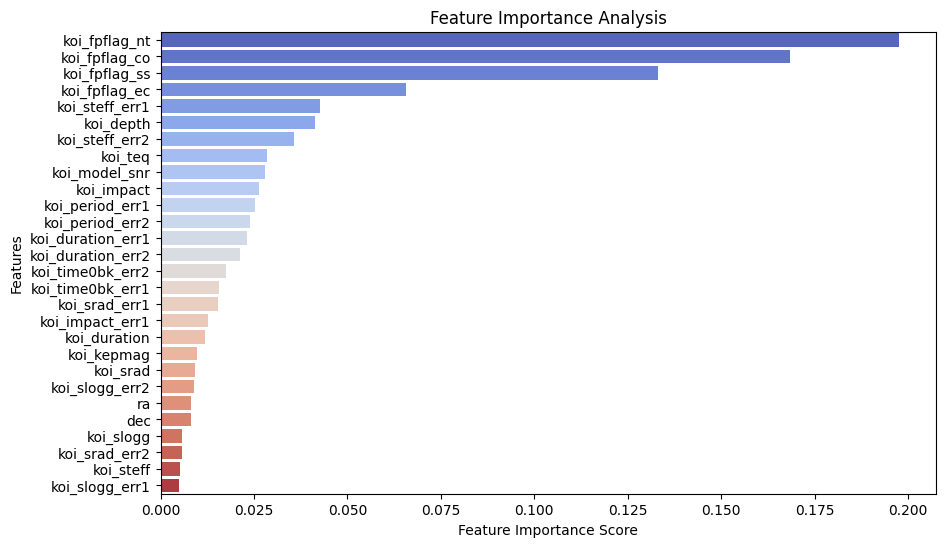


Low-Importance Features to Consider Removing: ['koi_slogg_err1']

Number of Features After Removal: 27


In [557]:
# FEATURE IMPORTANCE :
######################################################################################
feature_importances = best_rf.feature_importances_ 
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='coolwarm')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Analysis')
plt.show()

# Identify low-importance features (< 0.005) :
######################################################################################
low_importance_features = importance_df[importance_df['Importance'] < 0.005]['Feature'].tolist()
print("\nLow-Importance Features to Consider Removing:", low_importance_features)

# Remove low-importance features from dataset :
X_train = X_train.drop(columns=low_importance_features)
X_test = X_test.drop(columns=low_importance_features)

print(f"\nNumber of Features After Removal: {X_train.shape[1]}")

In [582]:
# Retrain with best parameters After Low Importance Features was Removed :
######################################################################################
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

train_accuracy_best_rf = accuracy_score(y_train, best_rf.predict(X_train))
test_accuracy_best_rf = accuracy_score(y_test, best_rf.predict(X_test))

cv_best_rf = grid_search.best_score_

print("Random Forest - Final Optimized Model : ")
print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", cv_best_rf)

print("\nTraining Accuracy Score:", train_accuracy_best_rf)
print("Testing Accuracy Score:", test_accuracy_best_rf)

#print("\nOptimized Model Classification Report:")
#print(classification_report(y_test, y_pred_best)) """

Random Forest - Final Optimized Model : 

Best Hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}
Best Cross-Validation Accuracy: 0.9840541659729427

Training Accuracy Score: 0.9950333289766043
Testing Accuracy Score: 0.989022477783586


### 3.2. Extremely Randomized Trees Classifier :

In [558]:
# EXTRA TREES CLASSIFIER - MODEL 1 : 
######################################################################################
et = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

et.fit(X_train, y_train)
train_accuracy_et = accuracy_score(y_train, et.predict(X_train))
test_accuracy_et = accuracy_score(y_test, et.predict(X_test))

print("Extra Trees Classifier - Baseline Model : ")
print("\nTraining Accuracy:", train_accuracy_et)
print("Testing Accuracy:", test_accuracy_et)

# CROSS-VALIDATION ACCURACY : 
######################################################################################
cv_scores = cross_val_score(et, X, y, cv=5, scoring='accuracy')
mean_cv_scores = np.mean(cv_scores)

print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", mean_cv_scores)

# CLASSIFIFCATION REPORT :
######################################################################################
print("\nClassification Report:")
print(classification_report(y_test, et.predict(X_test)))

Extra Trees Classifier - Baseline Model : 

Training Accuracy: 1.0
Testing Accuracy: 0.989022477783586

Cross-Validation Accuracy Scores: [0.97490852 0.99477261 0.96288552 0.99581809 0.9623431 ]
Mean Accuracy: 0.9781455664502074

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1014
           1       0.99      0.99      0.99       899

    accuracy                           0.99      1913
   macro avg       0.99      0.99      0.99      1913
weighted avg       0.99      0.99      0.99      1913



In [559]:
# HYPERPARAMETER TUNING WITH GRIDSEARCH :
######################################################################################
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Perform Grid Search with 5-fold cross-validation :
grid_search_et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_et.fit(X_train, y_train)

best_et = grid_search_et.best_estimator_
best_et.fit(X_train, y_train)

train_accuracy_best_et = accuracy_score(y_train, best_et.predict(X_train))
test_accuracy_best_et = accuracy_score(y_test, best_et.predict(X_test))

cv_best_et = grid_search.best_score_

print("Extra Trees Classifier - Optimized Model : ")
print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", cv_best_et)

print("\nTraining Accuracy:", train_accuracy_et)
print("Testing Accuracy:", test_accuracy_et)

Extra Trees Classifier - Optimized Model : 

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.984184884927191

Training Accuracy: 1.0
Testing Accuracy: 0.989022477783586


### 3.3. Gradient Boosting Classifier : 

In [560]:
# GRADIENT BOOSTING CLASSIFIER : 
######################################################################################
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
lgbm = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

train_accuracy_xgb = accuracy_score(y_train, xgb.predict(X_train))
test_accuracy_xgb = accuracy_score(y_test, xgb.predict(X_test))

train_accuracy_lgbm = accuracy_score(y_train, lgbm.predict(X_train))
test_accuracy_lgbm = accuracy_score(y_test, lgbm.predict(X_test))

print("\nXGBoost Classifier - Baseline Model : ")
print("Training Accuracy:", train_accuracy_xgb)
print("Testing Accuracy:", test_accuracy_xgb)

print("\nLightGBM Classifier - Baseline Model : ")
print("Training Accuracy:", train_accuracy_lgbm)
print("Testing Accuracy:", test_accuracy_lgbm)


XGBoost Classifier - Baseline Model : 
Training Accuracy: 1.0
Testing Accuracy: 0.9895452169367486

LightGBM Classifier - Baseline Model : 
Training Accuracy: 1.0
Testing Accuracy: 0.9900679560899112


In [ ]:
# HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH :
######################################################################################
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization
}

# Randomized Search with 5-fold cross-validation for XGBoost :
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", verbosity=0), 
    param_grid_xgb, 
    n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train, y_train)

# Randomized Search with 5-fold cross-validation for LightGBM :
random_search_lgbm = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=-1), 
    param_grid_lgbm, 
    n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search_lgbm.fit(X_train, y_train)

# Best hyperparameters and cross-validation scores :
best_xgb = random_search_xgb.best_estimator_
best_lgbm = random_search_lgbm.best_estimator_

train_accuracy_best_xgb = accuracy_score(y_train, best_xgb.predict(X_train))
test_accuracy_best_xgb = accuracy_score(y_test, best_xgb.predict(X_test))

train_accuracy_best_lgbm = accuracy_score(y_train, best_lgbm.predict(X_train))
test_accuracy_best_lgbm = accuracy_score(y_test, best_lgbm.predict(X_test))

cv_best_xgb = random_search_xgb.best_score_
cv_best_lgbm = random_search_lgbm.best_score_

print("\nXGBoost Classifier - Optimized Model:")
print("Best Hyperparameters:", random_search_xgb.best_params_)
print("Best Cross-Validation Accuracy:", cv_best_xgb)

print("Training Accuracy:", train_accuracy_best_xgb)
print("Testing Accuracy:", test_accuracy_best_xgb)

print("\nLightGBM Classifier - Optimized Model:")
print("Best Hyperparameters:", random_search_lgbm.best_params_)
print("Best Cross-Validation Accuracy:", cv_best_lgbm)

print("Training Accuracy:", train_accuracy_best_lgbm)
print("Testing Accuracy:", test_accuracy_best_lgbm)


XGBoost Classifier - Optimized Model:
Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best Cross-Validation Accuracy: 0.9848381381727522
Training Accuracy: 1.0
Testing Accuracy: 0.9884997386304234

LightGBM Classifier - Optimized Model:
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best Cross-Validation Accuracy: 0.984315433118599
Training Accuracy: 0.9941184158933473
Testing Accuracy: 0.989022477783586


### 3.4. AdaBoost Classifier : 

In [562]:
# ADABOOST CLASSIFIER : 
######################################################################################
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train, y_train)

train_accuracy_ada = accuracy_score(y_train, adaboost.predict(X_train))
test_accuracy_ada = accuracy_score(y_test, adaboost.predict(X_test))

print("AdaBoost Classifier - Baseline Model : ")
print("\nTraining Accuracy:", train_accuracy_ada)
print("Testing Accuracy:", test_accuracy_ada)

# CROSS-VALIDATION ACCURACY : 
######################################################################################
#cv_scores = cross_val_score(adaboost, X, y, cv=5, scoring='accuracy')
#mean_cv_scores = np.mean(cv_scores)

#print("\nCross-Validation Accuracy Scores:", cv_scores)
#print("Mean Accuracy:", mean_cv_scores)

AdaBoost Classifier - Baseline Model : 

Training Accuracy: 0.9854920925369233
Testing Accuracy: 0.9879769994772608


In [563]:
# HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH :
######################################################################################

adaboost_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Perform Randomized Search for AdaBoost :
adaboost_random_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=4), 
    adaboost_param_grid, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)
adaboost_random_search.fit(X_train, y_train)

best_ada = adaboost_random_search.best_estimator_

train_accuracy_best_ada = accuracy_score(y_train, best_ada.predict(X_train))
test_accuracy_best_ada = accuracy_score(y_test, best_ada.predict(X_test))

cv_best_ada = adaboost_random_search.best_score_

print("AdaBoost Classifier - Optimized Model : ")
print("\nBest Hyperparameters :", adaboost_random_search.best_params_)
print("Best Cross-Validation Accuracy :", cv_best_ada)

print("\nTraining Accuracy:", train_accuracy_best_ada)
print("Testing Accuracy:", test_accuracy_best_ada)


/Users/CentraleSupelec/Desktop/miniconda3/envs/mlclass/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/CentraleSupelec/Desktop/miniconda3/envs/mlclass/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/CentraleSupelec/Desktop/miniconda3/envs/mlclass/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/CentraleSupelec/Desktop/miniconda3/envs/mlclass/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

AdaBoost Classifier - Optimized Model : 

Best Hyperparameters : {'n_estimators': 200, 'learning_rate': 0.05, 'algorithm': 'SAMME.R'}
Best Cross-Validation Accuracy : 0.9832698698190893

Training Accuracy: 0.9832701607632989
Testing Accuracy: 0.9895452169367486


## 4. Results and Visualization :

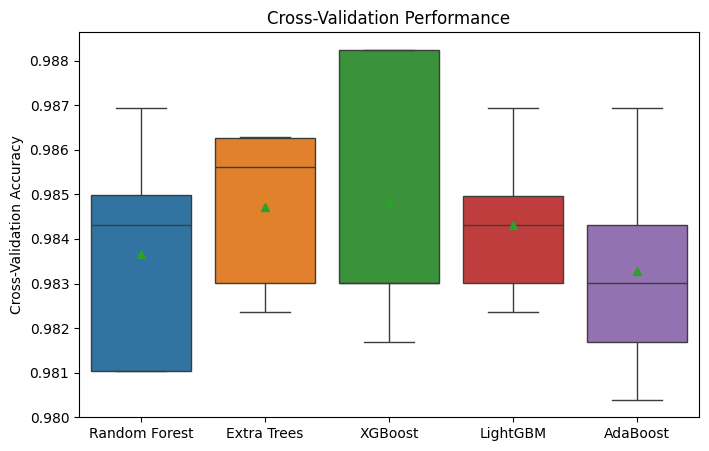

In [564]:
# CROSS-VALIDATION PERFORMANCE : 
######################################################################################
cv_scores_best_rf = cross_val_score(best_rf, X_train, y_train, cv=5)
cv_scores_best_et = cross_val_score(best_et, X_train, y_train, cv=5)
cv_scores_best_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5)
cv_scores_best_lgbm = cross_val_score(best_lgbm, X_train, y_train, cv=5)
cv_scores_best_ada = cross_val_score(best_ada, X_train, y_train, cv=5)

plt.figure(figsize=(8, 5))
sns.boxplot(data=[cv_scores_best_rf, cv_scores_best_et, cv_scores_best_xgb, cv_scores_best_lgbm, cv_scores_best_ada], showmeans=True)
plt.xticks([0, 1, 2, 3, 4], ["Random Forest", "Extra Trees", "XGBoost", "LightGBM", "AdaBoost"])
plt.ylabel("Cross-Validation Accuracy")
plt.title("Cross-Validation Performance")
plt.show()

In [565]:
# MODELS ACCURACY COMPARISON :
######################################################################################
model_comparison1 = pd.DataFrame({
    "Model": [
        "Random Forest",
        "Extra Trees",
        "XGBoost",
        "LightGBM",
        "AdaBoost"
    ],
    "Training Accuracy": [
        train_accuracy_best_rf,
        train_accuracy_best_et,
        train_accuracy_best_xgb,
        train_accuracy_best_lgbm,
        train_accuracy_best_ada
    ],
    "Testing Accuracy": [
        test_accuracy_best_rf,
        test_accuracy_best_et,
        test_accuracy_best_xgb,
        test_accuracy_best_lgbm,
        test_accuracy_best_ada
    ]
})
print("Training VS Testing Accuracy :\n", model_comparison1)

model_comparison2 = pd.DataFrame({
    "Model": [
        "Random Forest",
        "Extra Trees",
        "XGBoost",
        "LightGBM",
        "AdaBoost"
    ],
    "Testing Accuracy": [
        test_accuracy_best_rf,
        test_accuracy_best_et,
        test_accuracy_best_xgb,
        test_accuracy_best_lgbm,
        test_accuracy_best_ada
    ],
    "Cross-Validation Accuracy": [
        cv_best_rf,
        cv_best_et,
        cv_best_xgb,
        cv_best_lgbm,
        cv_best_ada
    ]
})
print("\n Testing VS Cross-Validation Accuracy :\n", model_comparison2)

Training VS Testing Accuracy :
            Model  Training Accuracy  Testing Accuracy
0  Random Forest           1.000000          0.988500
1    Extra Trees           1.000000          0.988500
2        XGBoost           1.000000          0.988500
3       LightGBM           0.994118          0.989022
4       AdaBoost           0.983270          0.989545

 Testing VS Cross-Validation Accuracy :
            Model  Testing Accuracy  Cross-Validation Accuracy
0  Random Forest          0.988500                   0.984185
1    Extra Trees          0.988500                   0.984185
2        XGBoost          0.988500                   0.984838
3       LightGBM          0.989022                   0.984315
4       AdaBoost          0.989545                   0.983270


In [568]:
# MODELS ACCURACY COMPARISON :
######################################################################################
model_comparison = pd.DataFrame({
    "Model": [
        "Random Forest",
        "Extra Trees",
        "XGBoost",
        "LightGBM",
        "AdaBoost"
    ],
    "Training Accuracy": [
        train_accuracy_best_rf,
        train_accuracy_best_et,
        train_accuracy_best_xgb,
        train_accuracy_best_lgbm,
        train_accuracy_best_ada
    ],
    "Testing Accuracy": [
        test_accuracy_best_rf,
        test_accuracy_best_et,
        test_accuracy_best_xgb,
        test_accuracy_best_lgbm,
        test_accuracy_best_ada
    ],
    "Cross-Validation Accuracy": [
        cv_best_rf,
        cv_best_et,
        cv_best_xgb,
        cv_best_lgbm,
        cv_best_ada
    ]
})
print("Training VS Teating VS Cross-Validation Accuracy :\n", model_comparison)

Training VS Teating VS Cross-Validation Accuracy :
            Model  Training Accuracy  Testing Accuracy  \
0  Random Forest           1.000000          0.988500   
1    Extra Trees           1.000000          0.988500   
2        XGBoost           1.000000          0.988500   
3       LightGBM           0.994118          0.989022   
4       AdaBoost           0.983270          0.989545   

   Cross-Validation Accuracy  
0                   0.984185  
1                   0.984185  
2                   0.984838  
3                   0.984315  
4                   0.983270  


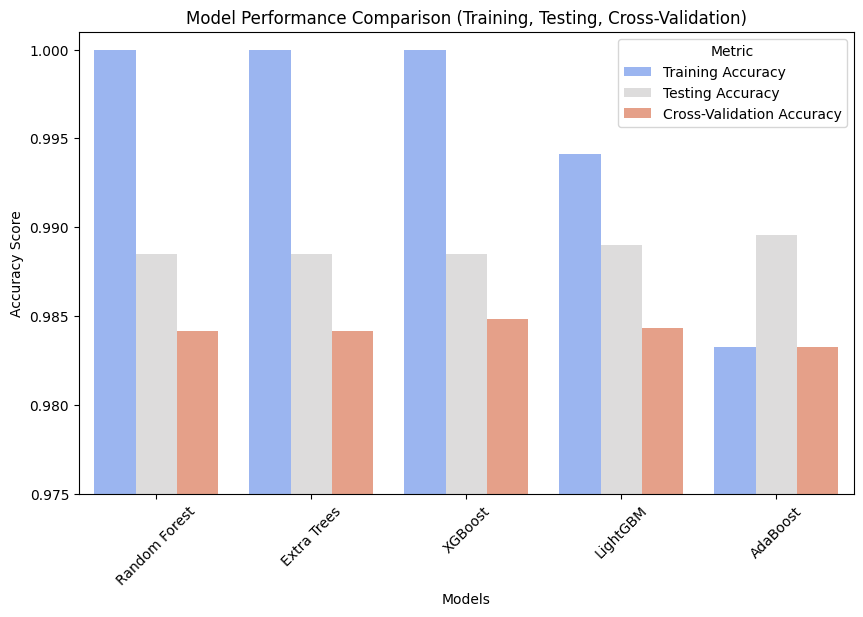

In [572]:
# VISUALIZATION OF MODEL COMPARISON :
######################################################################################
plt.figure(figsize=(10, 6))
model_comparison_long = model_comparison.melt(id_vars=["Model"], var_name="Metric", value_name="Accuracy")
sns.barplot(x="Model", y="Accuracy", hue="Metric", data=model_comparison_long, palette="coolwarm")
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Performance Comparison (Training, Testing, Cross-Validation)")
plt.ylim(0.975, 1.001)
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.show()


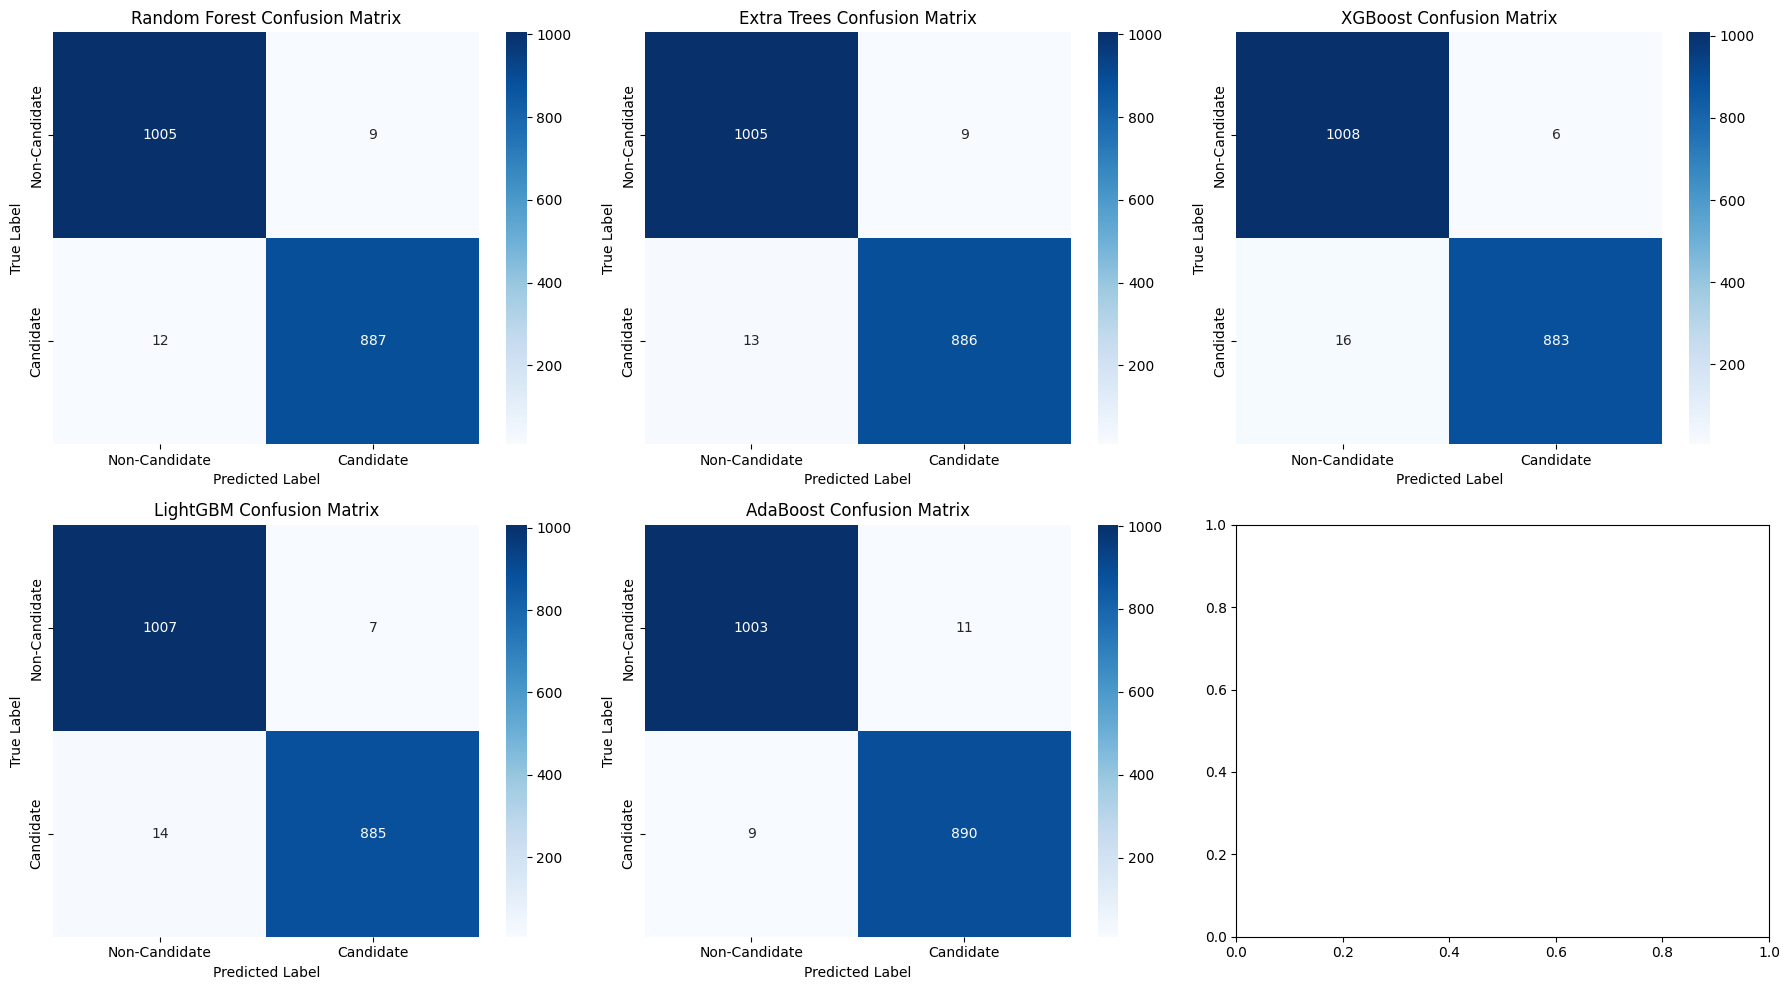

In [581]:
# CONFUSION MATRIX: 
######################################################################################
model_names = ["Random Forest", "Extra Trees", "XGBoost", "LightGBM", "AdaBoost"]
models = [best_rf, best_et, best_xgb, best_lgbm, best_ada]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

for i, (model, name) in enumerate(zip(models, model_names)):
    cm = confusion_matrix(y_test, model.predict(X_test))
    row, col = divmod(i, 3)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Candidate", "Candidate"], 
                yticklabels=["Non-Candidate", "Candidate"], ax=axes[row, col])
    
    axes[row, col].set_title(f"{name} Confusion Matrix")
    axes[row, col].set_xlabel("Predicted Label")
    axes[row, col].set_ylabel("True Label")

plt.tight_layout()
plt.show()


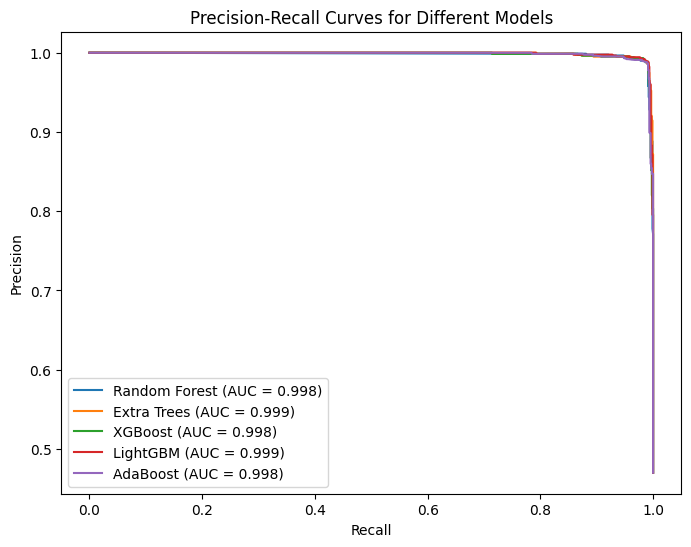

In [583]:
# PRECISION-RECALL CURVE : 
######################################################################################
plt.figure(figsize=(8, 6))

for model, name in zip(models, model_names):
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)  # Calculate AUC for PR Curve
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

# Plot random classifier line
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Different Models")
plt.legend()
plt.show()

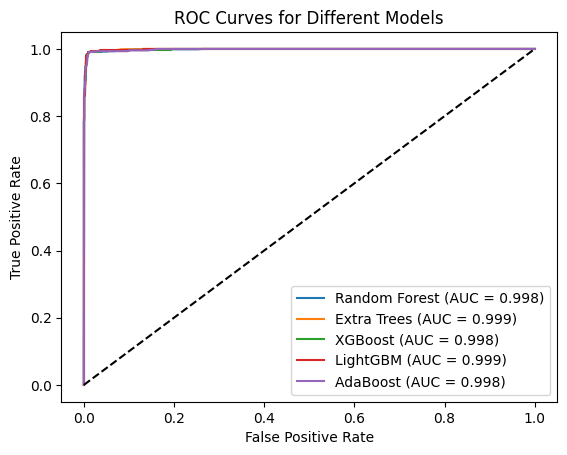

In [584]:
# ROC CURVES FOR DIFFERENT MODELS :
######################################################################################
#plt.figure(figsize=(8, 6))
for model, name in zip(models, model_names):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()